In [2]:
%matplotlib inline
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

# Helper Functions

In [3]:
## Turn a categorical variable into encoded integers
def Label(variable):
    le = preprocessing.LabelEncoder()
    labeled = le.fit_transform(variable)
    return labeled

## Goodness of the fit metric
def plot_roc_curve(target_test, target_predicted_proba,type_of_model=None):
    matplotlib.style.use('ggplot')
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    if type_of_model:
        plt.plot(fpr, tpr, label= type_of_model + ' (area = %0.3f)' % roc_auc)
    else:
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    

## Plotting unnormalized and normalized confusion matrices 
## The normalization gives the precision
def plot_confusion_matrix(Y_test, Y_predicted):

    matplotlib.style.use('ggplot')

    # confusion matrix colormap
    cmap=plt.cm.Blues
    
    # Compute confusion matrix
    cm = confusion_matrix(Y_test, Y_predicted)
    print(cm)
    np.set_printoptions(precision=2)


    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    print('Normalized confusion matrix')
    print(cm_normalized)
    
    plt.figure()
    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['expired','completed'], rotation=45)
    plt.yticks(tick_marks, ['expired','completed'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

#  All Projects in LA 

Projects table has most of the key features. But there are two potentially important features in donations table which need to be added to the projects table. 

In [22]:
projects_LA = pd.read_csv('projects_preProcessed.csv')
donations_LA = pd.read_csv('donations_preProcessed.csv')

Has the project been posted on a giving page or not?

In [36]:
# Number of donations received through a giving page
givingPage = donations_LA.groupby('_projectid')['via_giving_page'].sum()

# Turn into a binary variable --> posted or not posted on a giving page
def make_binary(x):
    if x >= 1:
        return 1
    else:
        return 0
    
givingPage = givingPage.apply(lambda x: make_binary(x))

Has the project been taken advantage of a promo code?

In [38]:
# Number of donations received through a giving page
promoCode = donations_LA.groupby('_projectid')['payment_was_promo_matched'].sum()

# Turn into a binary variable --> posted or not posted on a giving page
def make_binary(x):
    if x >= 1:
        return 1
    else:
        return 0
    
promoCode = promoCode.apply(lambda x: make_binary(x))

Putting donation features together:

In [46]:
donations_features = pd.DataFrame(dict(Giving_Page = givingPage, Promo_Code = promoCode)).reset_index()

Adding them to the projects table:

In [48]:
projects_LA = pd.merge(projects_LA,donations_features,how='inner',on=['_projectid','_projectid'])

In [50]:
donations_features.shape

(20165, 3)

In [51]:
projects_LA.to_csv('features.csv',index=False)

# Preprocessing

### Feature Selection

The feature engineering is done and it's just a matter of choosing the features. 

The end goal of this study is providing *actionable* insights. I need to find the balance between variance and bias in building classifiers. There are many features and some have many levels; like zipcode. That may lead to overfitting. It least for the first round of modeling, I will not include zipcode.

On the other hand, there are variables that are clearly correlated; like total price with and without optional support. I will use total price including optional support.

In [52]:
projects_LA.columns

Index([u'_projectid', u'school_zip', u'school_metro', u'school_charter',
       u'school_magnet', u'school_year_round', u'school_kipp',
       u'school_charter_ready_promise', u'teacher_teach_for_america',
       u'grade_level', u'total_price_excluding_optional_support',
       u'total_price_including_optional_support', u'students_reached',
       u'eligible_double_your_impact_match', u'eligible_almost_home_match',
       u'funding_status', u'funding_status_binary', u'resource_type_grouped',
       u'primary_focus_subject_grouped', u'secondary_focus_subject_grouped',
       u'poverty_level_grouped', u'teacher_gender', u'month_posted',
       u'semester_posted', u'previousProposal_Teacher',
       u'previousProposal_School', u'donor_per_zip', u'donation_per_zip',
       u'Giving_Page', u'Promo_Code'],
      dtype='object')

In [55]:
categorical_col_names =['school_metro', 'school_charter','school_magnet',\
                        'school_year_round', 'school_kipp','school_charter_ready_promise','teacher_gender',\
                        'teacher_teach_for_america', 'primary_focus_subject_grouped', \
                        'resource_type_grouped', 'poverty_level_grouped',\
                        'grade_level','eligible_double_your_impact_match', 'eligible_almost_home_match',\
                        'semester_posted','Promo_Code','Giving_Page']

continuous_col_names = ['total_price_including_optional_support', 'students_reached',\
                       'previousProposal_School','previousProposal_Teacher','donor_per_zip']

### Labeling and Normalizing

Sklearn accepts only numerical values and not string. Labeling will take care of that. 

For distance base algorithm like logic model, I need to eaither use OneHotEncoder or dummy variables.

In [56]:
# Labeling
features_array  = projects_LA[categorical_col_names]
features_array = features_array.apply(lambda x: Label(x))

And of course, it is better to normalize the numerical variables.

In [57]:
numerical_variables = projects_LA[continuous_col_names]

# Building an standart scaler
scaler = preprocessing.StandardScaler().fit(numerical_variables)
numerical_variables = scaler.transform(numerical_variables)                              

Take a quick look at the data:

In [58]:
features_array[continuous_col_names] = pd.DataFrame(numerical_variables)
features_array.head()

,school_metro,school_charter,school_magnet,school_year_round,school_kipp,school_charter_ready_promise,teacher_gender,teacher_teach_for_america,primary_focus_subject_grouped,resource_type_grouped,...,eligible_double_your_impact_match,eligible_almost_home_match,semester_posted,Promo_Code,Giving_Page,total_price_including_optional_support,students_reached,previousProposal_School,previousProposal_Teacher,donor_per_zip
0,2,0,0,1,0,0,0,1,3,0,...,0,0,0,0,0,-0.012749,0.087914,-0.772517,-0.510298,-0.817347
1,2,0,0,1,0,0,0,1,3,0,...,0,0,0,0,0,-0.280323,-0.091934,-0.772517,-0.510298,-0.817347
2,2,1,0,0,0,0,1,1,3,1,...,0,0,0,0,0,1.643948,0.297736,-0.798943,-0.572333,-0.266408
3,2,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1.492450,0.447609,-0.825368,-0.603351,-0.992754
4,2,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0.043432,0.747356,0.090717,-0.510298,2.753091


Ok, looks good.

### Spliting the data into train/test sets

70% of the data will be used for training and the remaining 30% for testing the classifier.

In [59]:
target_binary = projects_LA.funding_status_binary

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target_binary, test_size=0.30, random_state=123)

# Model Fitting Using Ensemble Methods

I will use Random Forest Classifier and Gradient Boosting Classifier. They are both powerful and tree based. I am hoping to minimize the overfitting using ensemble methods. 

I will use these methods to find *important actionable* variable to be used for logistic regression.

## Random Forest 

### Grid Search 

GridSearchCV is a great way for finding good parameters. My laptop is pretty old so I will do the grid search for only 30 trees. Cross Validation (5 folds) is used to for finding the parameters which yields the highest mean AUC. Pretty awesome!

- criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
- max_features: The precentage of features to consider when looking for the best split
- max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_leaf: The minimum number of samples in newly created leaves. A split is discarded if after the split, one of the leaves would contain less then min_samples_leaf samples. 

In [280]:
%%time

rf = RandomForestClassifier(n_estimators=100)

params = {
    'criterion': ['entropy','gini'],
    'max_features': [0.2, 0.6, 0.9],
    'max_depth': [2, 6, 12],
    'min_samples_leaf' : [5, 20, 50]
}
rf = GridSearchCV(rf, params, cv=10, scoring='roc_auc')
rf.fit(features_train, target_train)

CPU times: user 46min 23s, sys: 41.4 s, total: 47min 5s
Wall time: 1h 17min 11s


In [281]:
sorted(rf.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[1:10]

[mean: 0.83385, std: 0.01211, params: {'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5},
 mean: 0.83234, std: 0.01279, params: {'max_features': 0.2, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5},
 mean: 0.83234, std: 0.01184, params: {'max_features': 0.6, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5},
 mean: 0.83214, std: 0.01161, params: {'max_features': 0.9, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5},
 mean: 0.83105, std: 0.01182, params: {'max_features': 0.6, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 20},
 mean: 0.83072, std: 0.01145, params: {'max_features': 0.9, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5},
 mean: 0.83026, std: 0.01194, params: {'max_features': 0.9, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 20},
 mean: 0.82968, std: 0.01253, params: {'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 20},
 mean:

In [282]:
print 'best score is ', rf.best_score_
print 'best parameters are ', rf.best_params_

best score is  0.834226424404
best parameters are  {'max_features': 0.6, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5}


### Using the Best Parameters

Can use this parameters for higher number of estimators to gain a more robust model. For sure, it would be ideal to use higher n_estimators during the grid search but it would take forever!

In [60]:
%%time

rf_final = RandomForestClassifier(n_estimators=500, criterion='entropy', 
                                  max_features=0.6, max_depth=12, min_samples_leaf=5)

rf_final.fit(features_train, target_train)

CPU times: user 22 s, sys: 241 ms, total: 22.3 s
Wall time: 23.9 s


### Evaluating the Model 

#### Precision & Recall 

About 70% of all projects are funded. Therefore, the baseline will be considered all projects are funded. Below is the comparision between the baseline and random forest model.

In [61]:
print 'baseline case:'
print(classification_report(target_test, len(rf_final.predict(features_test))*[1],
                            target_names=['expired', 'completed']))
print
print 'Random Forest'
print(classification_report(target_test, rf_final.predict(features_test),
                            target_names=['expired', 'completed']))

baseline case:
             precision    recall  f1-score   support

    expired       0.00      0.00      0.00       836
  completed       0.86      1.00      0.93      5214

avg / total       0.74      0.86      0.80      6050


Random Forest
             precision    recall  f1-score   support

    expired       0.63      0.28      0.39       836
  completed       0.89      0.97      0.93      5214

avg / total       0.86      0.88      0.86      6050



In [284]:
print 'baseline case:'
print(classification_report(target_test, len(rf_final.predict(features_test))*[1],
                            target_names=['expired', 'completed']))
print
print 'Random Forest'
print(classification_report(target_test, rf_final.predict(features_test),
                            target_names=['expired', 'completed']))

baseline case:
             precision    recall  f1-score   support

    expired       0.00      0.00      0.00      2164
  completed       0.84      1.00      0.92     11746

avg / total       0.71      0.84      0.77     13910


Random Forest
             precision    recall  f1-score   support

    expired       0.69      0.32      0.44      2164
  completed       0.89      0.97      0.93     11746

avg / total       0.86      0.87      0.85     13910



Definitely, better than the baseline. Although, the recall for expired projects is not that great. There are many expired projects that are considered funded. Anyway, again, much better than the baseline :)

#### Confusion Matrix 

Confusion matrix provides a nice visualization of the goodness of the model. The normalized matrix shows the precision for expired and completed (funded and not funded) projects.

[[  697  1467]
 [  306 11440]]
Normalized confusion matrix
[[ 0.69  0.11]
 [ 0.31  0.89]]


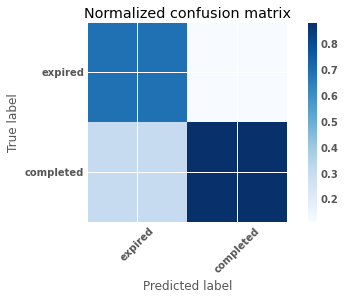

In [285]:
plot_confusion_matrix(target_test,rf_final.predict(features_test))

#### ROC_AUC 

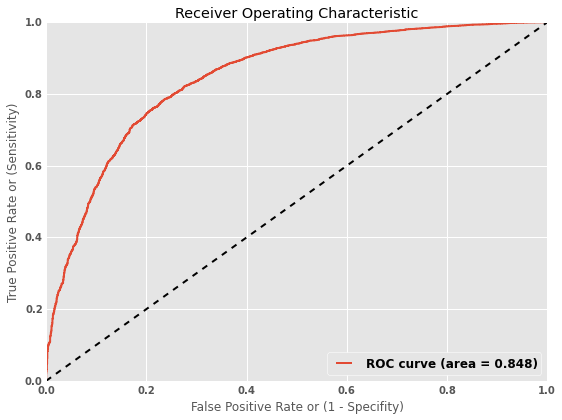

In [286]:
plt.figure(figsize=(8,6))
plot_roc_curve(target_test, rf_final.predict_proba(features_test))

### Variable Importance

And finally the variable importance. It's key to actionable insights. Let's see how many of top 10 features are actionable.

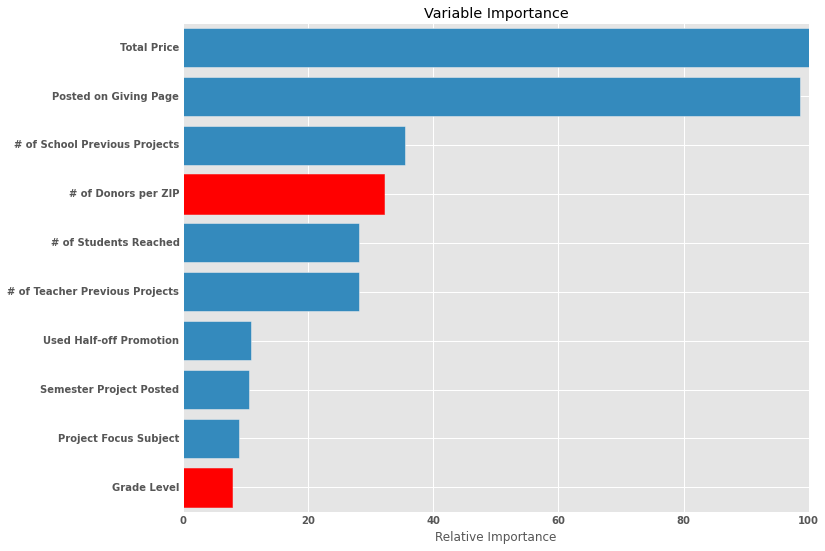

In [278]:
plt.figure(figsize=(10,18))

# Plot feature importance
feature_importance = rf_final.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(2,1,2)

# Use nicer labels -- Second iteration
feature_labels = [u'Grade Level', u'Project Focus Subject', u'Semester Project Posted',
       u'Used Half-off Promotion',u'# of Teacher Previous Projects',u'# of Students Reached',
       u'# of Donors per ZIP',u'# of School Previous Projects', u'Posted on Giving Page', u'Total Price']
barlist = plt.barh(pos, feature_importance[sorted_idx], align='center')
barlist[0].set_color('r')
barlist[6].set_color('r')
plt.yticks(pos, feature_labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Gradient Boosting 

In [ ]:
%%time

gb = GradientBoostingClassifier(n_estimators=100,subsample=0.8,learning_rate=0.1)

params = {
    'loss': ['exponential','deviance'],    
    'max_features': [0.2, 0.6, 0.9],
    'max_depth': [2, 6, 12],
    'min_samples_leaf' : [5, 20, 50]
}
gb = GridSearchCV(gb, params, cv=10, scoring='roc_auc')
gb.fit(features_train, target_train)

In [ ]:
sorted(gb.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[1:10]

In [226]:
print gb.best_score_
print gb.best_params_

0.833783119769
{'max_features': 0.2, 'loss': 'exponential', 'max_depth': 12, 'min_samples_leaf': 20}


### Using the Best Parameters

In [233]:
%%time 

gb_final = GradientBoostingClassifier(loss='exponential', n_estimators=500, subsample=0.8, 
                                learning_rate=0.1,max_features=0.2, max_depth=12,
                                min_samples_leaf=20)

gb_final.fit(features_train, target_train)

CPU times: user 1min 55s, sys: 893 ms, total: 1min 56s
Wall time: 2min 16s


### Evaluating the Model 

#### Precision & Recall 

Now, we can compare random forest and gradiest boosting:

In [238]:
print 'Random Forest:'
print(classification_report(target_test, rf_final.predict(features_test),
                            target_names=['expired', 'completed']))
print
print 'Gradient Boosting'
print(classification_report(target_test, gb_final.predict(features_test),
                            target_names=['expired', 'completed']))

Random Forest:
             precision    recall  f1-score   support

    expired       0.70      0.33      0.45      2164
  completed       0.89      0.97      0.93     11746

avg / total       0.86      0.87      0.85     13910


Gradient Boosting
             precision    recall  f1-score   support

    expired       0.62      0.38      0.47      2164
  completed       0.89      0.96      0.92     11746

avg / total       0.85      0.87      0.85     13910



Interesting! For completed class, both do well. But if the goal was finding the expired class, gradient boosting has a higher recall. Although random forest has higher precision but gradient boosting has higher f1-score. Go GB!

#### Confusion Matrix 

[[  832  1332]
 [  511 11235]]
Normalized confusion matrix
[[ 0.62  0.11]
 [ 0.38  0.89]]


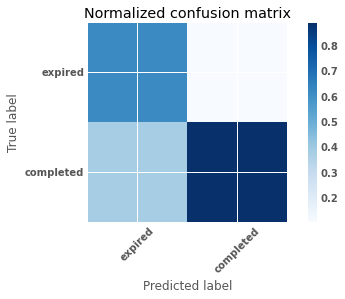

In [240]:
plot_confusion_matrix(target_test,gb_final.predict(features_test))

#### ROC_AUC 

Let's compare random forest and gradient boosting:

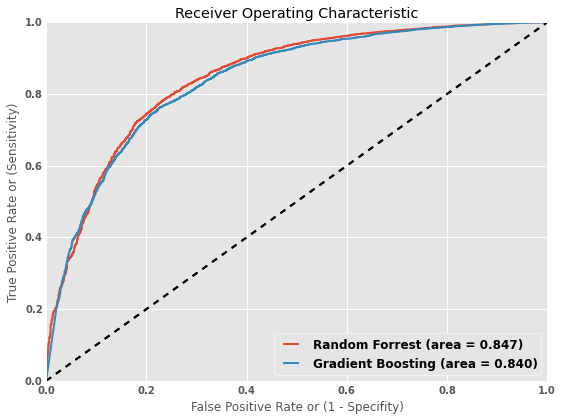

In [242]:
plt.figure(figsize=(8,6))
plot_roc_curve(target_test, rf_final.predict_proba(features_test),type_of_model='Random Forrest')
plot_roc_curve(target_test, gb_final.predict_proba(features_test),type_of_model='Gradient Boosting')

I guess here random forest wins! But for low precision, maybe gradient boosting is doing better. Anyway, the difference is so small. They both do pretty well.

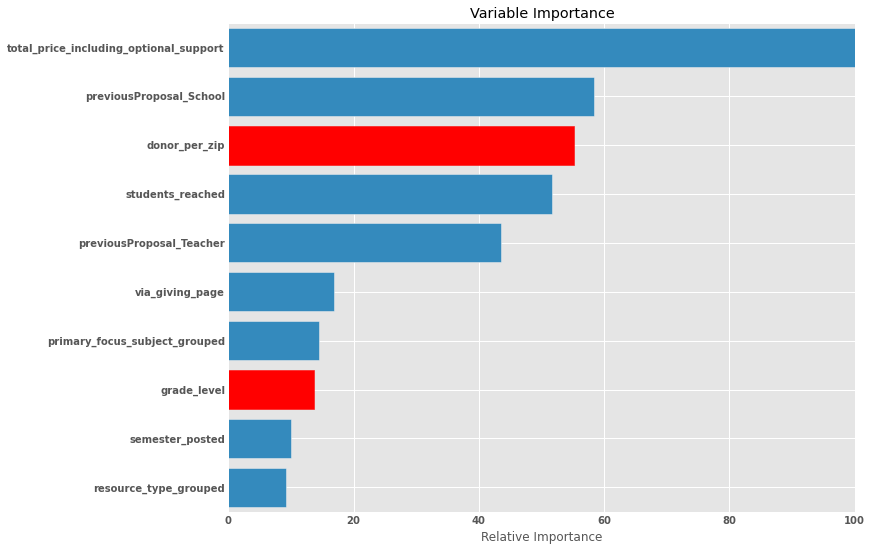

In [249]:
plt.figure(figsize=(10,18))

# Plot feature importance
feature_importance = gb_final.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(2,1,2)
feature_labels = ['Project Resource Type','Semester Project Posted', 'Grade Level', 'Project Focus Subject',
       u'Posted on Giving Page' ,'# of Teacher Previous Projects', u'# of Students Reached','# of Donors per ZIP',
       '# of School Previous Projects', 'Total Price']
barlist = plt.barh(pos, feature_importance[sorted_idx], align='center')
barlist[2].set_color('r')
barlist[7].set_color('r')
plt.yticks(pos, features_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The top 10 important variables are similar for random forest and gradient boosting. No dount that the total price is the most important variable. Here is a list of **actionale important variables**:

- Total Price
- School & Teacher number of Previous Proposals
- Posting the Project on the Giving Page
- The Semester the Project is Poster (1st vs. 2nd)
- Number of Students Impacted
- Focus Subject of the Project (Art, Math, and etc.)
- Using Half-off Promotions
- Requested Resource Type (Book&Supplies, Technology, and etc.)

Now, we are ready for a parsimonious model. I will use these features for a Logistic Regression model in order to quantify the effect of each feature.

R Logistic Regression package is very handy. Let's switch to R.